## Setup

In [1]:
import os
def savefig(fig, name):
    if not os.path.exists('images'):
        os.makedirs('images')
    fig.savefig('images/' + name + '.png')

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Let's start

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

The `sklearn.datasets` package contains mostly three types of functions: `fetch_*` functions such as `fetch_openml()` to download real-life datasets, `load_*` function to load small toy datasets bundled with Scikit-Learn, and `make_*` functions to generate fake datasets, useful for tests.

They generally contain the following entries:

- "DESCR": A description of the dataset.
- "data": The input data , usually as a 2D NumPy array.
- "target": The labels, usually as a 1D NumPy array.

The `fetch_openml()` return the input as the Pandas DataFrame and labels as the Pandas Series. We set `as_frame` = **false** because there are img data, Pandas DataFrame is not proper.

In [3]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [4]:
X.shape

(70000, 784)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
y.shape

(70000,)

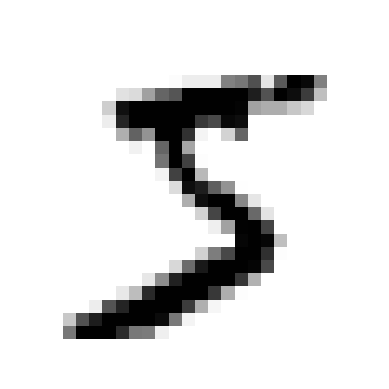

In [7]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap = 'binary')
    plt.axis('off')

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [8]:
y[0] # show a label of X[0]

'5'

## Create a test set

The MNIST dataset returned by `fetch_openml()` is actually split into a training set the first 60,000 images is the training set and a test is the last 10,000 images

In [9]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

## Training a Binary Classifier

In [10]:
y_train_5 = (y_train == '5') # True for all 5s, False for all other digits.
y_test_5 = (y_test == '5')

We use SGD Classifier because this classifier is capable of handling very large datasets efficiently.

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
# predict some digit
sgd_classifier.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). Look like it guessed right in this particular case!

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor. There are many performance measures available: 

### Measuring Accuracy Using Cross-validation

Let use the `cross_val_score()` function to evaluate our SGDClassifier model, using k-fold cross-validation with three folds. Remember that k-fold means splitting the training set into k folds, then train model k times, holding out a different fold each time for evaluation.

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_classifier, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

We can see there are above 95% accuracy on all cross-validation folds.

Let's look at a dummy classifier that just classifies every single image in the most frequent class, which in this case is the negative class. 

In [14]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy = 'most_frequent')
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # prints False: no 5s detected

False


In [15]:
cross_val_score(dummy_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.90965, 0.90965, 0.90965])

About 90% accuracy because only about 10% of the images are 5s, so if you always guess that an image is *not* a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifier, especially when you are dealing with *skewed datasets* (i.e., when some classes are much more frequent than others). A much better way to evaluate the performance of a classifier is *confusion matrix*.

### Confution Matrices

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. You could make prediction on test set, but it's best to keep untouched for now. Instead, you can use `cross_val_predict()`:

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_5, cv = 3)

Just look like `cross_val_score()` function, `cross_val_predict()` performs k-folds, but instead of returning a evaluation, it return the prediction of each fold.

Now make the confusion matrix

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represent an *actual class*, while each column represents a *predicted class*.

The first row of matrix consider non-5 images (the negative class). 53,892 of them were correctly classified as non 5s (they are called True negatives - TN). While the remaining 687 were wrongly classified of 5s (the false positives, also called I type errors).

The second row of matrix consider the images of 5s (the positive class). 1,891 were wrongly classified as non 5s. (false negatives, also called type II errors), while 3,530 remaining were correctly classified as 5s (True positives). A prefect classifier would only have TP and TN.

In [18]:
y_train_prefect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_prefect_predictions)

array([[54579,     0],
       [    0,  5421]])

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the *presicion of the classifier*:

$$\text{precision} = \frac{TP}{TP + FP}$$

A trivial way to have perfect precision is to create a classifier that always makes negative predictions, except for one single positive prediction on the instance it’s most confident about. If this one prediction is correct, then the classifier has 100% precision (precision = 1/1 = 100%). Obviously, such a classifier would not be very useful, since it would ignore all but one positive instance. So, precision is typically used along with another metric named recall, also called sensitivity or the true positive rate (TPR): this is the ratio of positive instances that are correctly detected by the classifier

$$\text{recall} = \frac{TP}{TP + FN}$$

### Precision and Recall

Scikit-Learn provides several functions to compute classifier metrics, including `precision` and `recall`

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # = 3530 / (687 + 3530): when model claims that it is 5, it is correct in 83% of cases

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred) # = 3530 / (1891 + 3530): detects 65% of 5s

0.6511713705958311

It is often convenient to combine precision and recall into a single metric called the F1 score, especially when you need a single metric to compare two classifiers. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

$$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FP + FN}{2}}$$

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred) # = 2 * (0.83 * 0.65) / (0.83 + 0.65)

0.7325171197343847

### The Precision/Recall Trade-off

The $F_1$ score favors classifier that have similar precision and recall. This is not always what you want: in some cases, you most care about precision, and in other cases you really care about recall. For ex:

- If you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product.
- On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier only has 30% precision as long as it has 99% recall.

To understand this trade-off, let’s look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s `predict()` method, you can call its `decision_function()` method, which returns a score for each instance, and then use any threshold you want to make predictions based on those score:

In [22]:
y_score = sgd_classifier.decision_function([some_digit])
y_score

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the preceding code returns the same result as `predict()` method. Let's raise the threshold:

In [24]:
threshold = 3000
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 3,000.

How do you decide which threshold to use? First, use the `cross_val_predict()` function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:

In [25]:
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv = 3, method = 'decision_function')

With these score, use the precision_recall_curve() function to compute precision and recall for all possible threshold (the function adds a last precision of 0 and a last
recall of 1, corresponding to an infinite threshold):

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, use Matplotlib to plot precision and recall as functions of the threshold value. Let's show the threshold of 3,000 we selected:

In [27]:
thresholds.shape

(60000,)

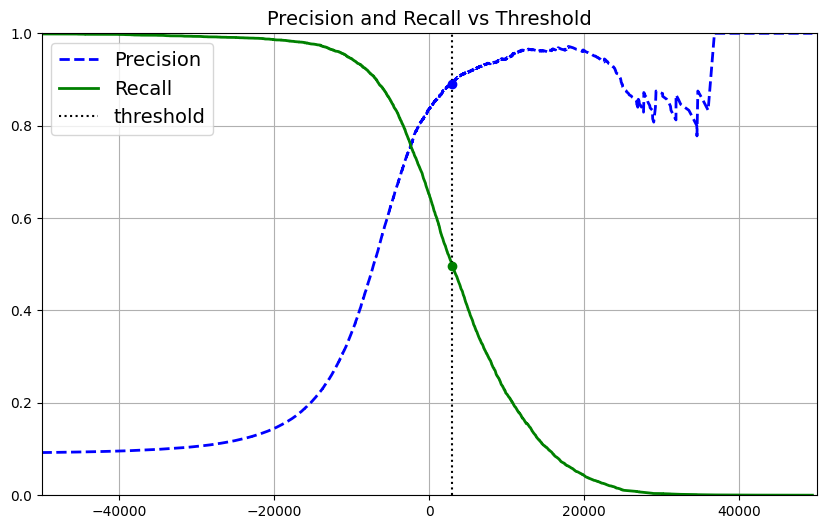

In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label = "Precision", linewidth = 2)
plt.plot(thresholds, recalls[:-1], 'g-', label = "Recall", linewidth = 2)
plt.vlines(threshold, 0, 1.0, 'k', 'dotted', label = 'threshold')
plt.grid('True')
plt.legend()
idx = (thresholds >= threshold).argmax() # first index >= threshold
plt.plot(thresholds[idx], precisions[idx], 'bo')
plt.plot(thresholds[idx], recalls[idx], 'go')
plt.axis([-50000, 50000, 0, 1])
plt.title('Precision and Recall vs Threshold')
savefig(plt, 'precision_recall_vs_threshold_plot')
plt.show()

Why the precision curve is bumpier than recall curve in this Figure. The reason is that precision may sometimes go down when you raise the threshold. To understand why, look back Figure 3-4 and notice what happens when you raise the threshold by move it just one digit to the right; precision goes down from 4/5 (80%) to (3/4) 75%. On the other hand, recall can only go down when the threshold is increased.

At this threshold value, precision is near 90% and recall is around 50% . Another way to select a good precision/recall trade-off is plot precision directly against recall, as shown in Figure 3-6

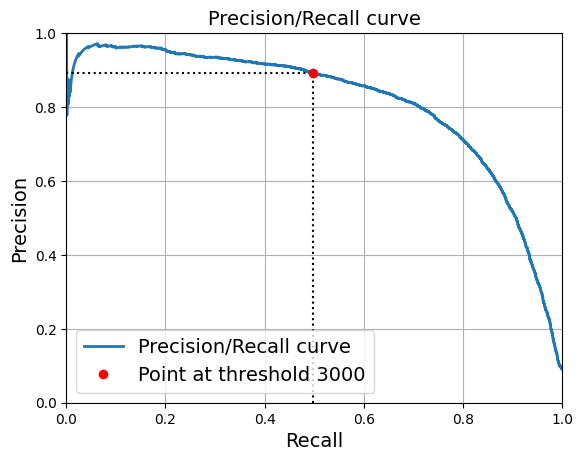

In [29]:
plt.plot(recalls, precisions, linewidth = 2, label = 'Precision/Recall curve')
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], 'k:')
plt.plot([0., recalls[idx]], [precisions[idx], precisions[idx]], 'k:')
plt.plot(recalls[idx], precisions[idx], 'ro', label = 'Point at threshold 3000')
plt.axis([0,1,0,1])
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall curve')
plt.legend()
savefig(plt, 'precision_recall_curve')
plt.show()

You can see that precision really starts to fall sharply at around 80% recall. You will probably want to select a precision/recall trade-off just before that drop for example, at around 60% recall. But of course, the choice depends on your project.

Suppose you decide to aim for 90% precision. You could use the first plot to find the threshold you need to use, but that's not very precise. Alternately, you can search for the lowest threshold that gives you at least 90% precision. You can use NumPy array's `argmax()` method. This return first index of maximum value, which in this case means the first **True** value

In [30]:
idx_for_90_precision = (precisions >= 0.9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

To make predictions (on the training set for now), instead of calling the classifier's `predict()` method, you can run:

In [31]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [32]:
precision_at_90_precision = precision_score(y_train_5, y_train_pred_90)
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)

In [33]:
print(precision_at_90_precision, recall_at_90_precision)

0.9000345901072293 0.4799852425751706


Great, you have a 90% precision classifier! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set high enough threshold, and you're done. But it make recall is too low! For many applications, 48% recall wouldn't be great at all.

We will try 99% precision

In [34]:
idx_for_99_precision = (precisions >= 0.99).argmax()
threshold_for_99_precision = thresholds[idx_for_99_precision]
threshold_for_99_precision

36801.60697028177

In [35]:
y_train_pred_99 = (y_scores >= threshold_for_99_precision)

In [36]:
precision_at_99_precision = precision_score(y_train_5, y_train_pred_99)
recall_at_99_precision = recall_score(y_train_5, y_train_pred_99)

In [37]:
print(precision_at_99_precision, recall_at_99_precision)

1.0 0.0009223390518354548


We can see precision is 100% but recall is approx to 0.

### The ROC Curve

The *receiver operating characteristic* (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC plotting curve plots the *true positive rate* (another name of recall) against the *false positive rate* (FPR). The FPR is also called the *fall-out*, is the ratio of negative instances are incorrectly classified as positive. It is equal to `1-TNR` TNR is true negative rate, which is the ratio of negative instances are correctly classified as negative.

The TNR is also called *specificity*. Hence, the ROC curve plots *sensitivity* (recall) versus 1 - *specificity*. 

In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

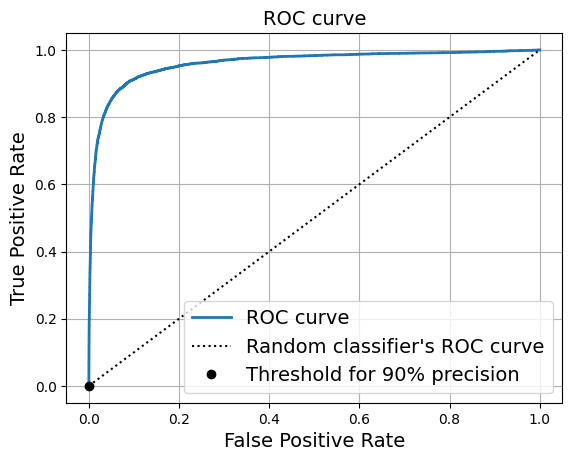

In [39]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr , linewidth = 2, label = 'ROC curve')
plt.plot([0, 1], [0, 1], 'k:', label = 'Random classifier\'s ROC curve')
plt.plot([fpr_90], [tpr_90], 'ko', label = "Threshold for 90% precision")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.grid()
savefig(plt, 'roc_curve')
plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the *area under the curve* (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have ROC AUC equal to 0.5. Scikit-learn provides a function to estimate the ROC AUC:

In [40]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let's create a RandomForestClassifier, whose PR curve and F1 score we can compare to those of the SGDclassifier

In [41]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

The `precision_recall_curve()` function expects labels and socres for each instances, so we need to train the random forest classifier and make it assign a score to each instance. But the `RandomForestClassifier` class does not have a `decision_function()` method, due to the way it works. Luckily, it has a `predict_proba()` method that returns class probabilities for each instance, and we can just use the probability of the positive class as a score.

In [42]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

Let's look at the class probabilities for the first two images in training set.

In [43]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The second column contains the estimated probabilities for the positive class, so let's pass them to `precision_recall_curve()` function:

In [44]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

Now we're ready to plot the PR curve.

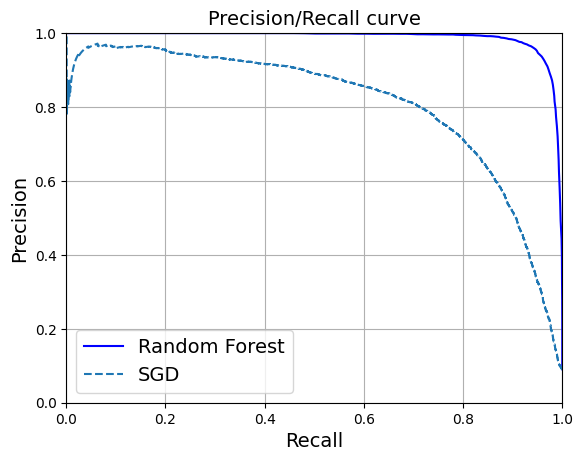

In [45]:
plt.plot(recalls_forest, precisions_forest, 'b-', label = 'Random Forest')
plt.plot(recalls, precisions, '--', label = 'SGD')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.axis([0, 1, 0, 1])
plt.title('Precision/Recall curve')
savefig(plt, 'precision_recall_curve_random_forest')
plt.show()

As you can see, the RandomForestClassifier's PR curve looks much better than the SGDClassifier's.

In [46]:
y_train_pred_forest = (y_probas_forest[:, 1] >= 0.5)  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [47]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

Whereas binary classification distinguish between two classes, *multiclass classifier* can distinguish between more than two classes.

Some Scikit-Learn classifiers (Logistic Regression, RandomForestClassifier, and GaussianNB) are capable of handling multiple classes . Others are strictly binary classifiers (SGDClassifier, SVC).

One way to create a system that can classify the digit images into 10 classes (from 0 - 9) is train 10 classifiers, one for each digit (a 0-detector, 1-detector, ...). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs highest score. This is called the *one-versus-the-rest* (OvR) strategy.

Another strategy is to train a binary classifier for every pair of digits. If there are $N$ classes, you need to train $N \times (N-1) / 2$ classifiers. For MNIST problems, this means training 45 binary classifiers! This is called the *one-versus-one* (OvO). The main advantage of OvO is that each classifier only needs to be trained on the part of the training set containing the two classes that it must distinguish.

Some algorithms (such as SVC) scale poorly with size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small set than to train few classifiers on large set.

In [48]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

We trained the SVC using the original target classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes (y_train_5). Since there are 10 classas (>= 2). Scikit-learn used the OvO strategy and trained 45 binary classifiers. Now let's make a prediction on an image:

In [49]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [50]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

The highest score is 9.3, and it's indeed the one corresponding to class 5:

In [51]:
class_id = some_digit_scores.argmax()
class_id

5

When a classifier is trained, it stores the list of target classes in its `classes_attribute` ordered by value.

In [52]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [53]:
svm_clf.classes_[class_id]

'5'

If you want to force Scikit-Learn to use OvO or OvR, you can use the `OneVsOneClassifier` and `OneVsRestClassifier` classes.

In [54]:
# create a multiclass classifier using the OvR strategy, based on SVC
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [55]:
# make prediction
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [56]:
len(ovr_clf.estimators_) # 10 classes

10

Training an SGDClassifier on multiclass dataset and using it to make predictions is just as easy:

In [58]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

But that's incorrect. Prediction errors do happen! This time Scikit-Learn used the OvR strategy under the hood: since there are 10 classes, it trained 10 binary classifier. The `decision_function()` method now returns one value per class.

In [61]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

You can see that the classifier is not very confident about its prediction: all most all scores are negative, while class 3 has a score 1824, and class 5 has -1386. 

In [64]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

## Error Analysis

First, look at the confusion matrix. For this, you first need to make predictions using the `cross_val_prediction()` function; themn you can pass the labels and predictions to the `confusion_matrix()` function. However, since there are now 10 classes instead of 2, the confusion matrix will contain quite a lot of numbers, it may be hard to read.

A colored diagram of the confusion matrix is much easier to analyze. To plot such a diagram, use `ConfusionMatrixDisplay.from_predictions()`

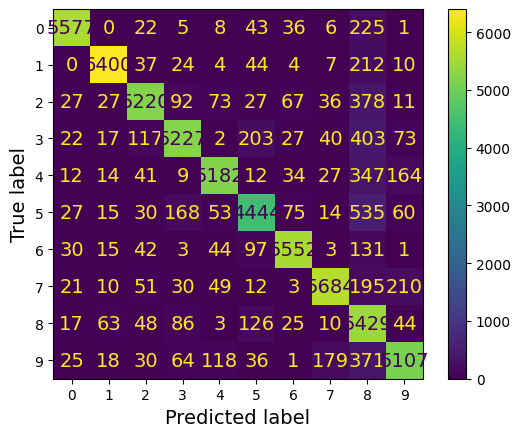

In [70]:
from sklearn.metrics import ConfusionMatrixDisplay
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
savefig(plt, 'confusion_matrix')
plt.show()

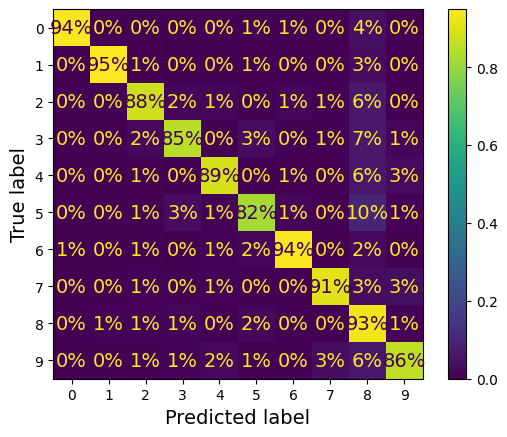

In [69]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize = 'true', values_format = ".0%")
savefig(plt, 'confusion_matrix_normalized')
plt.show()